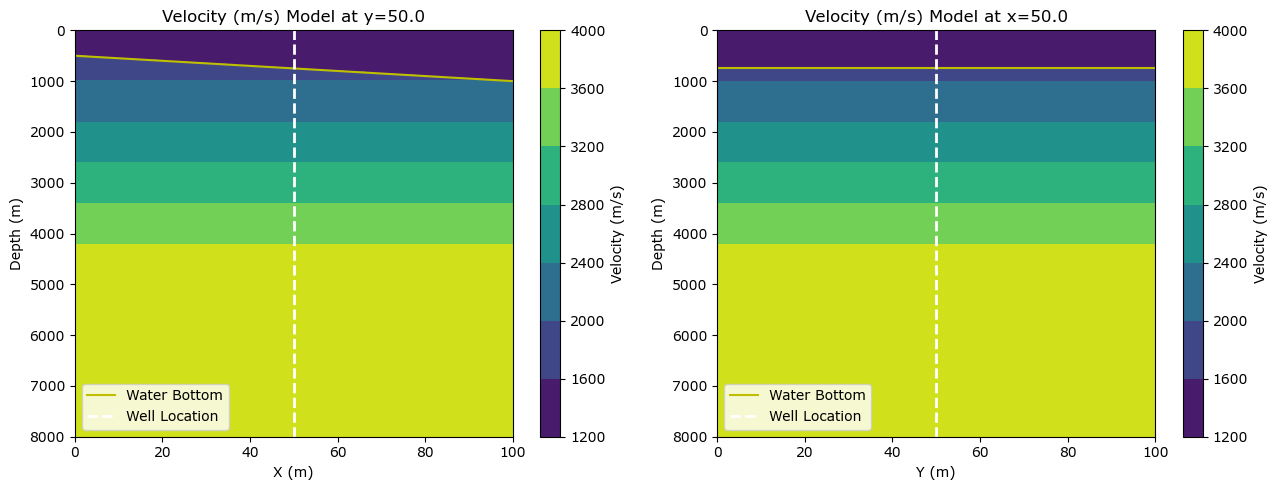

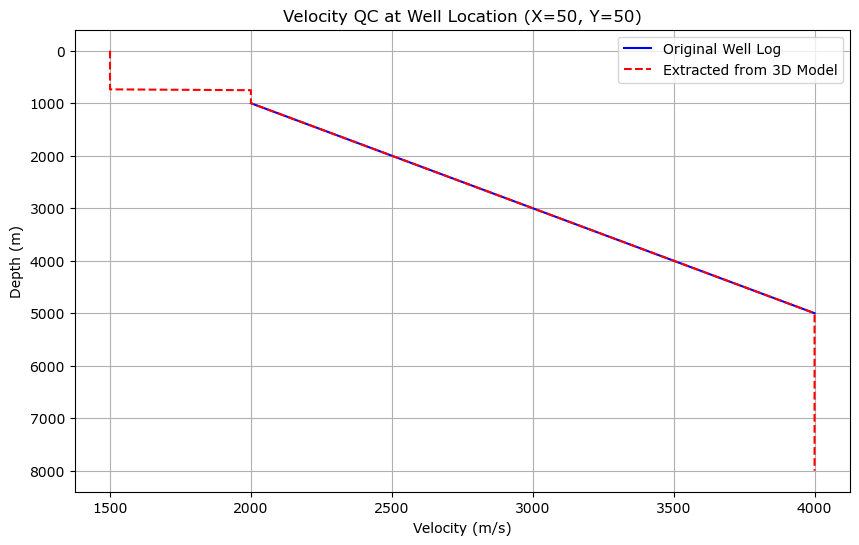

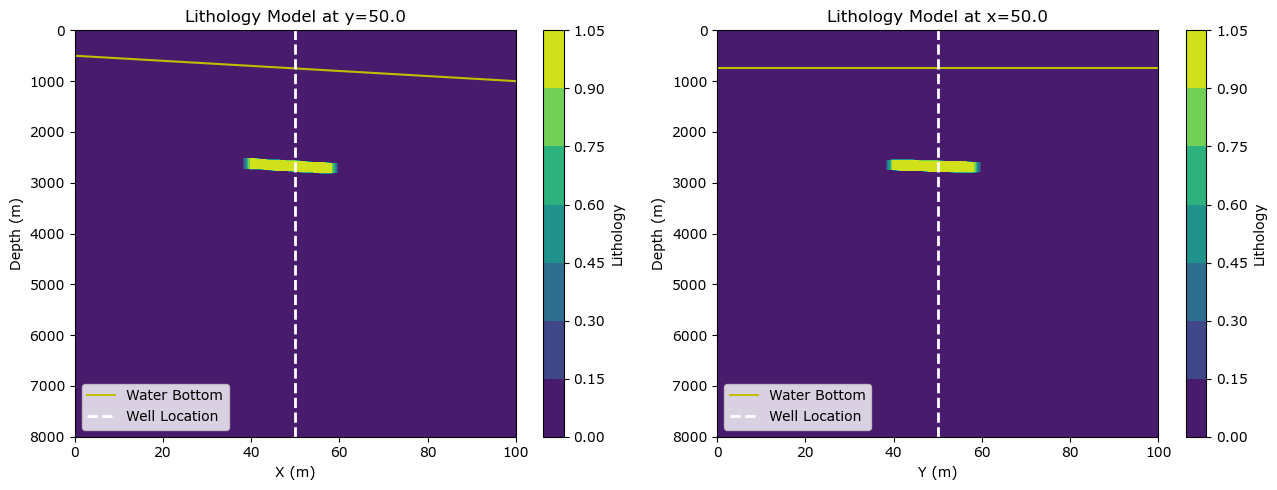

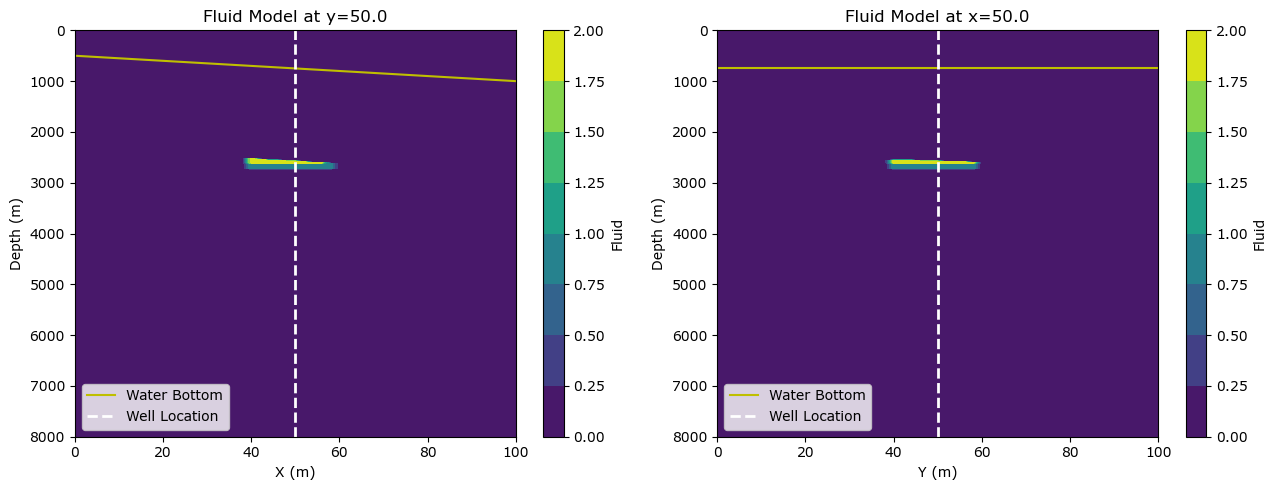

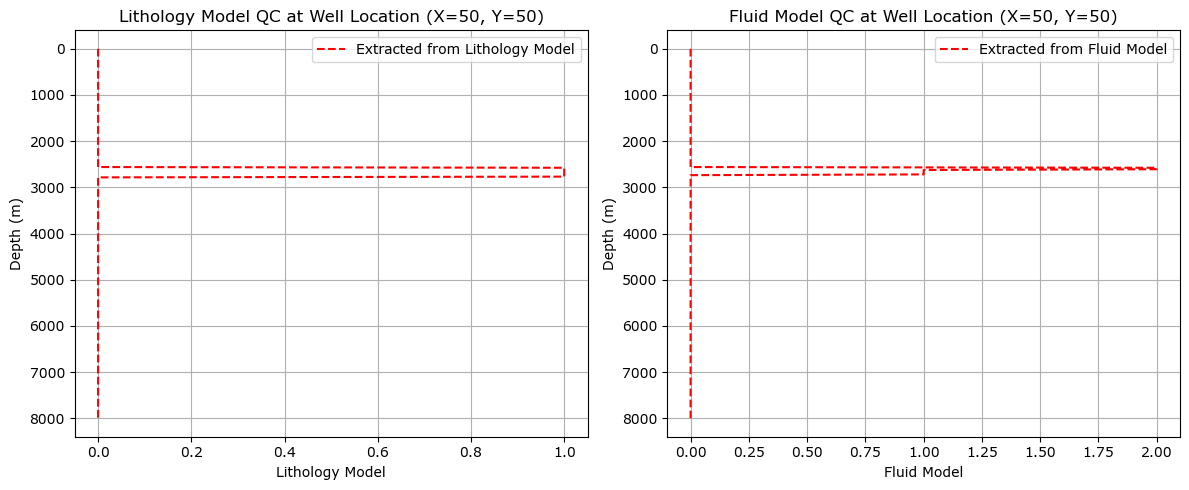

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from plot_model_sections import plot_model_sections
from plot_well_profiles import plot_well_profiles

# Define grid of 3D model

# Example well log data
depth = np.array([1000, 2000, 3000, 4000, 5000])  # Depths in meters
velocity = np.array([2000, 2500, 3000, 3500, 4000])  # Velocity in m/s

# Create a 3D grid where we want to estimate velocity
x_grid = np.linspace(0, 100, 51)
y_grid = np.linspace(0, 100, 51)
depth_grid = np.linspace(0, 8000, 501)

# Interpolate the well log velocity data to the depth grid
interpolated_velocity = np.interp(depth_grid, depth, velocity)

# Initialize the velocity model
velocity_model = np.zeros((len(x_grid), len(y_grid), len(depth_grid)))

# Populate the velocity model laterally with the interpolated velocity profile
for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        velocity_model[i, j, :] = interpolated_velocity

# Define well location
x_well = 50  # x-coordinates of the well
y_well = 50  # y-coordinates of the well

# Define water bottom surface

def surface_depth(x, y):
    return 500 + 5 * x + 0 * y  # Example linear surface equation
  
surface_array =np.zeros((len(x_grid),len(y_grid)))

# Populate the surface array
index = 0
for i, xi in enumerate(x_grid):
    for j, yi in enumerate(y_grid):
        surface_array[i,j]=surface_depth(xi,yi)
        index += 1

# Mute above water bottom to 1500 m/s
surface_3d = np.expand_dims(surface_array, axis=-1)  # Expand dimensions to match depth grid
surface_3d = np.repeat(surface_3d, len(depth_grid), axis=-1)  # Repeat to match the depth dimension

velocity_model[depth_grid<surface_3d]=1500

# QC inine and xline
plot_model_sections(velocity_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Velocity (m/s)', y_index=25, x_index=25)

# Extract and display well velocity profile
well_x_index = np.argmin(np.abs(x_grid - x_well))
well_y_index = np.argmin(np.abs(y_grid - y_well))
extracted_velocity = velocity_model[well_x_index, well_y_index, :]

# Plot the original well log velocities vs. the interpolated velocities
plt.figure(figsize=(10, 6))
plt.plot(velocity, depth, label='Original Well Log', color='blue')
plt.plot(extracted_velocity, depth_grid, label='Extracted from 3D Model', color='red', linestyle='--')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Depth (m)')
plt.title('Velocity QC at Well Location (X=50, Y=50)')
plt.gca().invert_yaxis()  # Depth increases downwards
plt.legend()
plt.grid(True)

# Define sand body

# Define the range for the sand body in terms of x and y coordinates
x_min, x_max = 40, 60
y_min, y_max = 40, 60

# Define the dipping sand body parameters
slope_x = 10  # Slope in x direction (meters per unit x)
slope_y = 5   # Slope in y direction (meters per unit y)
thickness = 200  # Thickness of the sand body in depth units

# Find the index range for the sand body in the x and y and depth grids
x_min_index = np.searchsorted(x_grid, x_min)
x_max_index = np.searchsorted(x_grid, x_max)
y_min_index = np.searchsorted(y_grid, y_min)
y_max_index = np.searchsorted(y_grid, y_max)

# Initialize lithology model
lithology_model=np.zeros((len(x_grid), len(y_grid), len(depth_grid)),dtype='int')

# Loop through the grid and assign 1 to the sand body within the specified range
for i in range(x_min_index, x_max_index):
    for j in range(y_min_index, y_max_index):
        # Calculate the depth of the sand body at this (x, y) location
        sand_depth_top = 2500 + slope_x * (i - x_min_index) + slope_y * (j - y_min_index)
        sand_depth_bottom = sand_depth_top + thickness

        # Find the depth indices corresponding to the sand body
        top_index = np.searchsorted(depth_grid, sand_depth_top)
        bottom_index = np.searchsorted(depth_grid, sand_depth_bottom)

        # Assign 1 to the sand body within the defined depth range
        lithology_model[i, j, top_index:bottom_index] = 1

# QC inine and xline
plot_model_sections(lithology_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Lithology', y_index=25, x_index=25)

# Define fluid content and GOC, OWC

#Initialize fluid model
fluid_model = np.zeros((len(x_grid), len(y_grid), len(depth_grid)),dtype='int')

# Calculate the absolute top and bottom of the sand body
sand_depth_top_abs = 2500  # Top of the sand body at the smallest x, y
sand_depth_bottom_abs = sand_depth_top_abs + thickness + slope_x * (x_max_index - x_min_index) + slope_y * (y_max_index - y_min_index)

# Find the depth indices for the top and bottom of the sand body
top_index_abs = np.searchsorted(depth_grid, sand_depth_top_abs)
bottom_index_abs = np.searchsorted(depth_grid, sand_depth_bottom_abs)

# Calculate the height of the entire sand body
sand_height_abs = bottom_index_abs - top_index_abs

# Calculate indices for the top, middle, and bottom thirds
gas_index_abs = top_index_abs + sand_height_abs // 3
oil_index_abs = top_index_abs + 2 * sand_height_abs // 3


# Loop through the grid and assign 2 for gas zone, 1 for oil zone and 0 for water zone in the sand body
for i in range(x_min_index, x_max_index):
    for j in range(y_min_index, y_max_index):
        for k in range(top_index_abs, bottom_index_abs):
            if lithology_model[i, j, k] == 1:  # Check if it's part of the sand body
                if k < gas_index_abs:
                    fluid_model[i, j, k] = 2  # Gas
                elif k < oil_index_abs:
                    fluid_model[i, j, k] = 1  # Oil
                else:
                    fluid_model[i, j, k] = 0  # Water

# QC inine and xline
plot_model_sections(fluid_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Fluid', y_index=25, x_index=25)

# QC well profiles
plot_well_profiles(lithology_model, fluid_model, x_grid, y_grid, depth_grid, model_1_name='Lithology Model', model_2_name='Fluid Model')


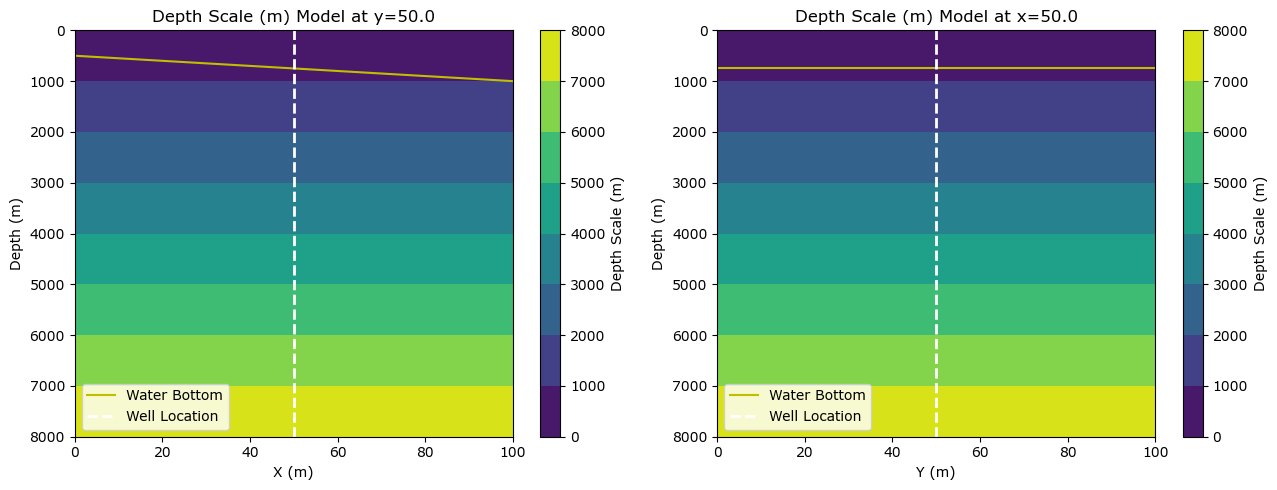

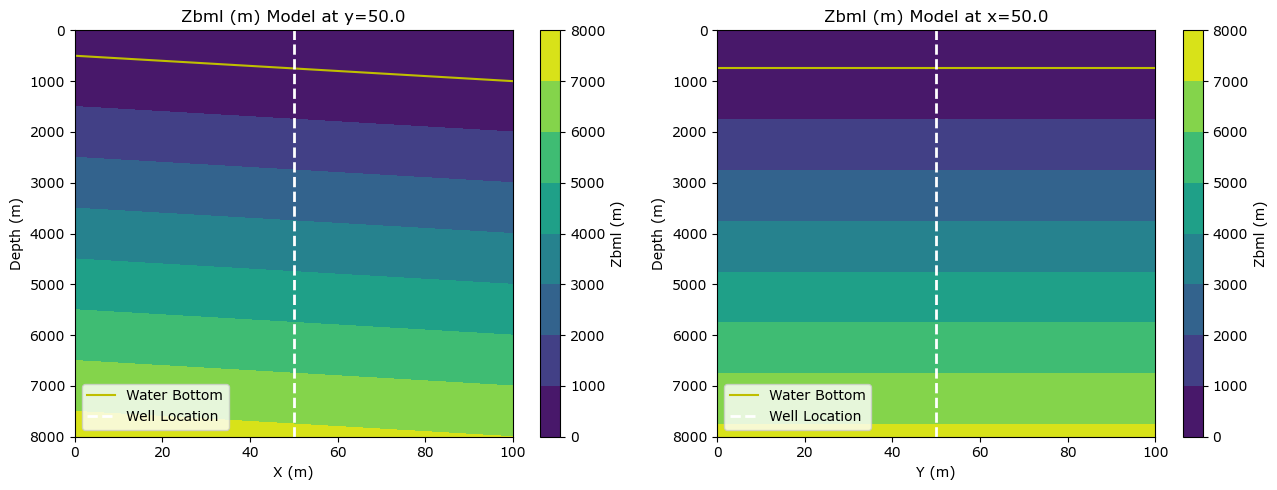

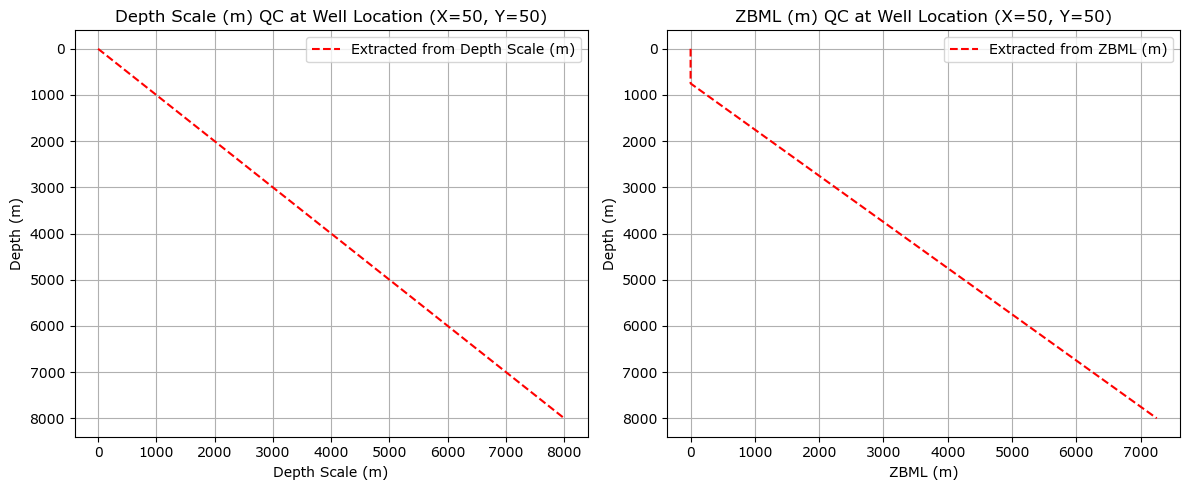

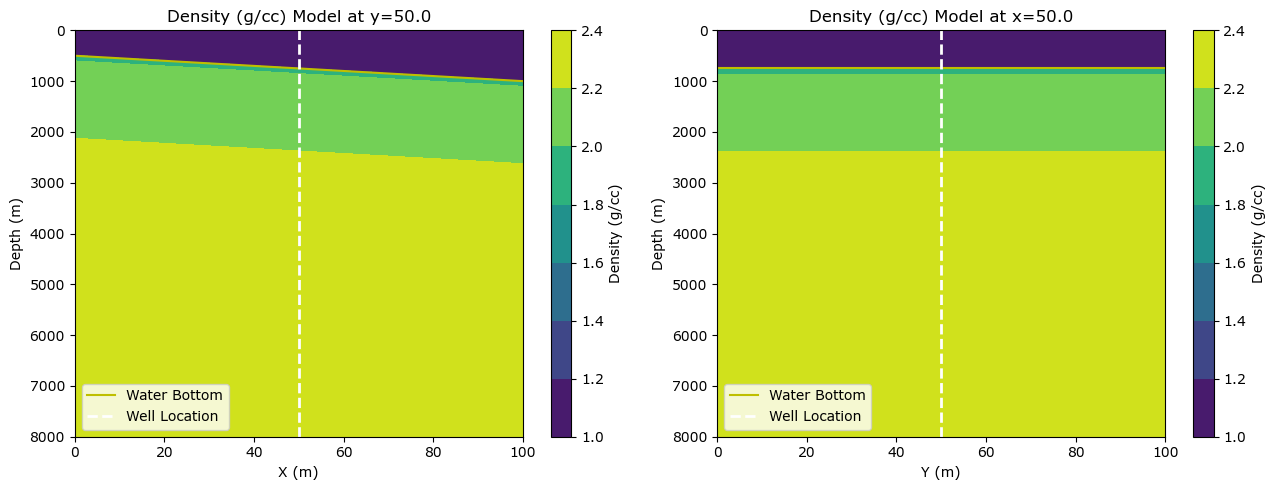

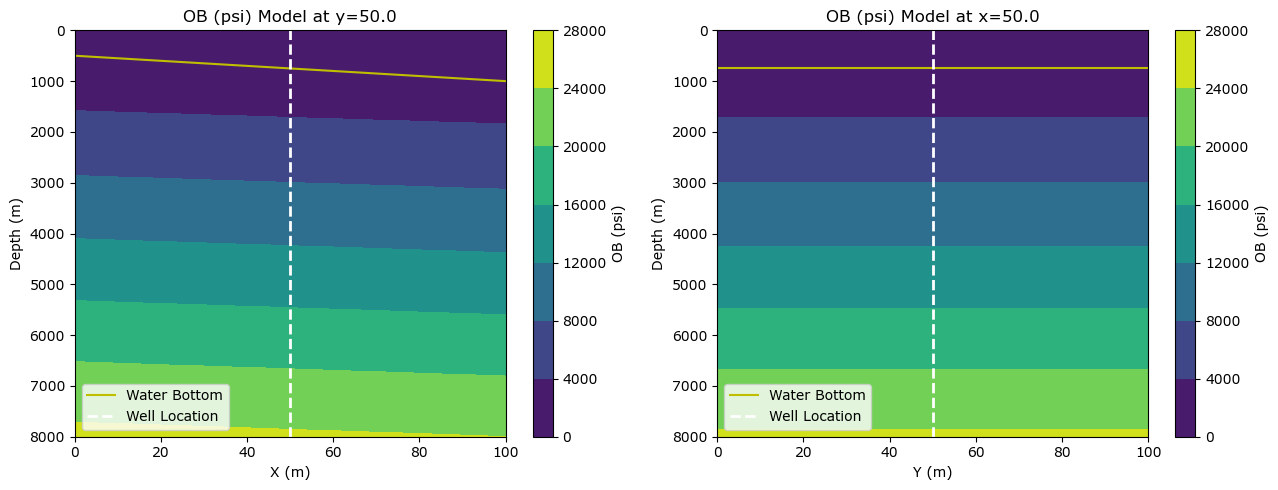

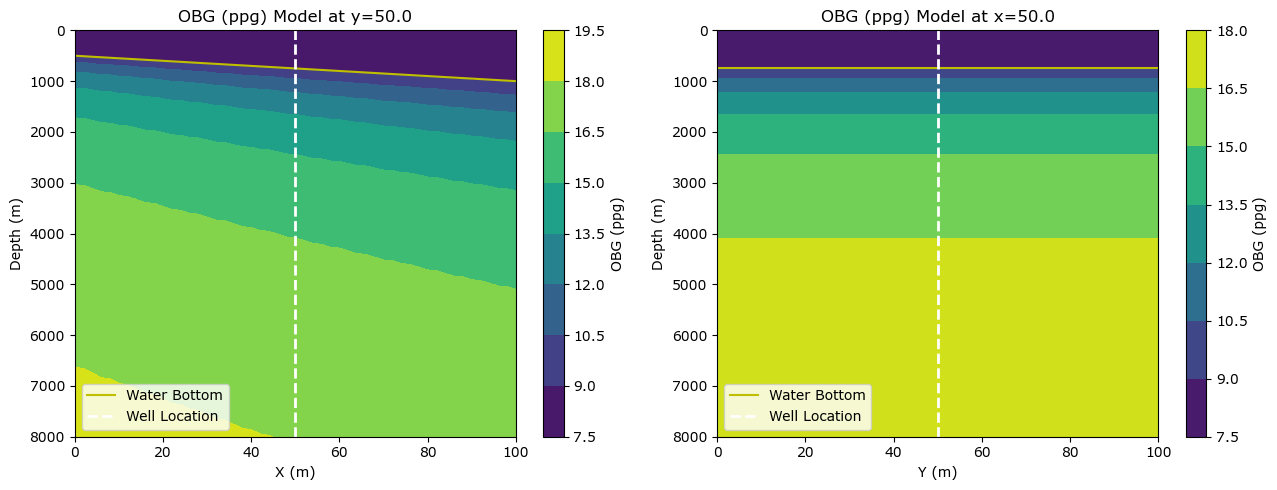

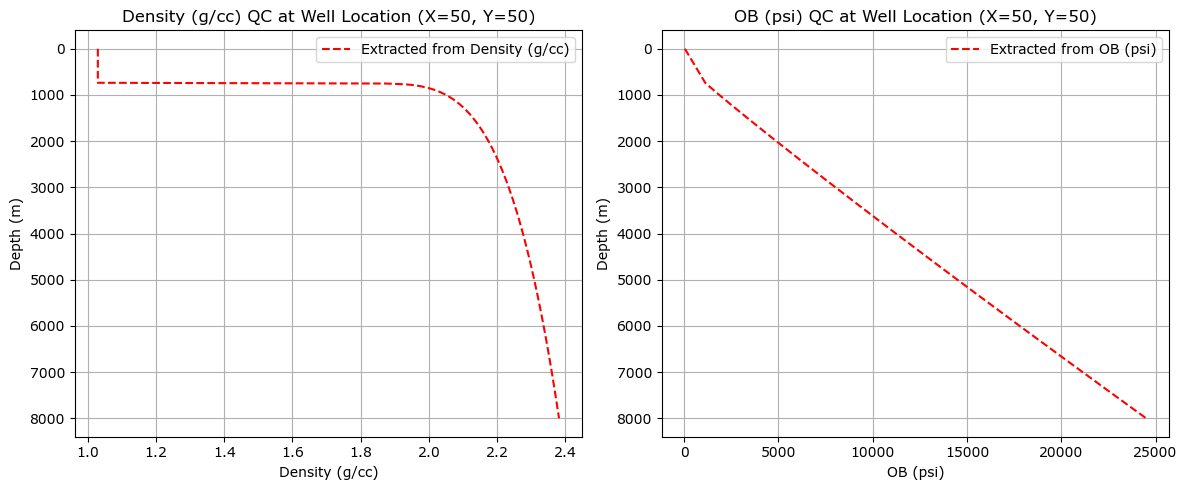

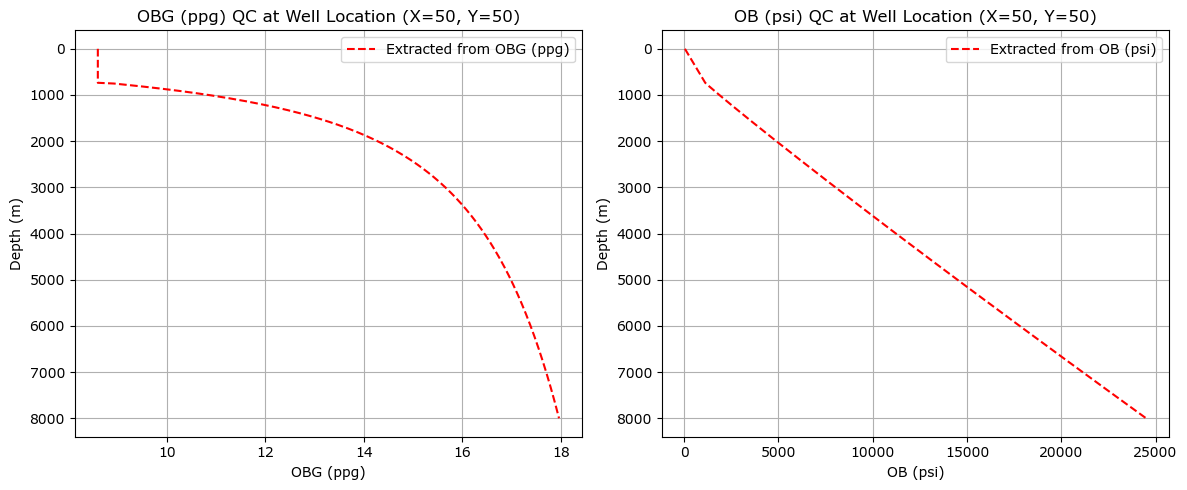

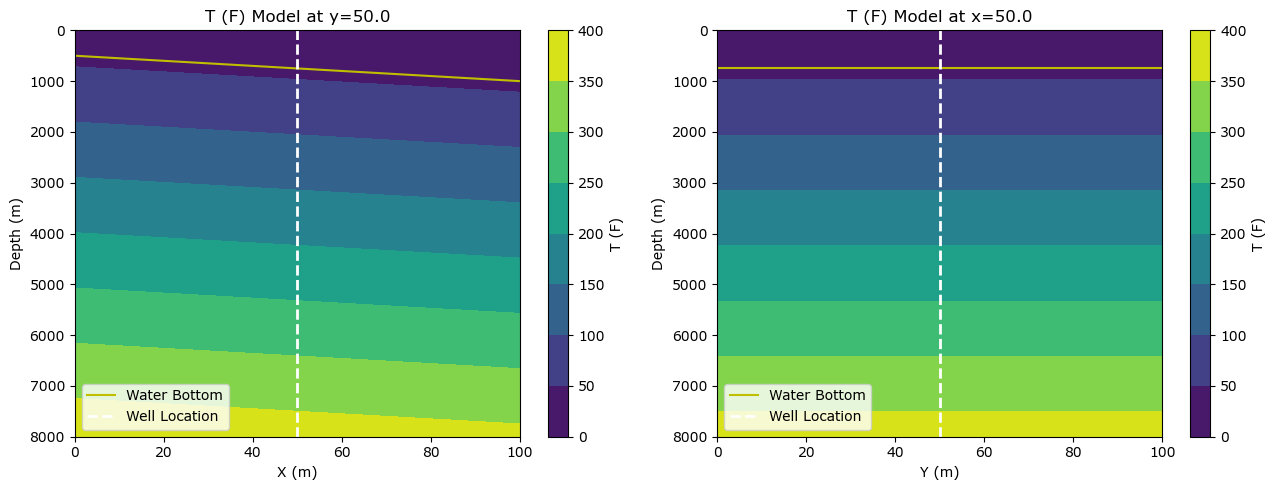

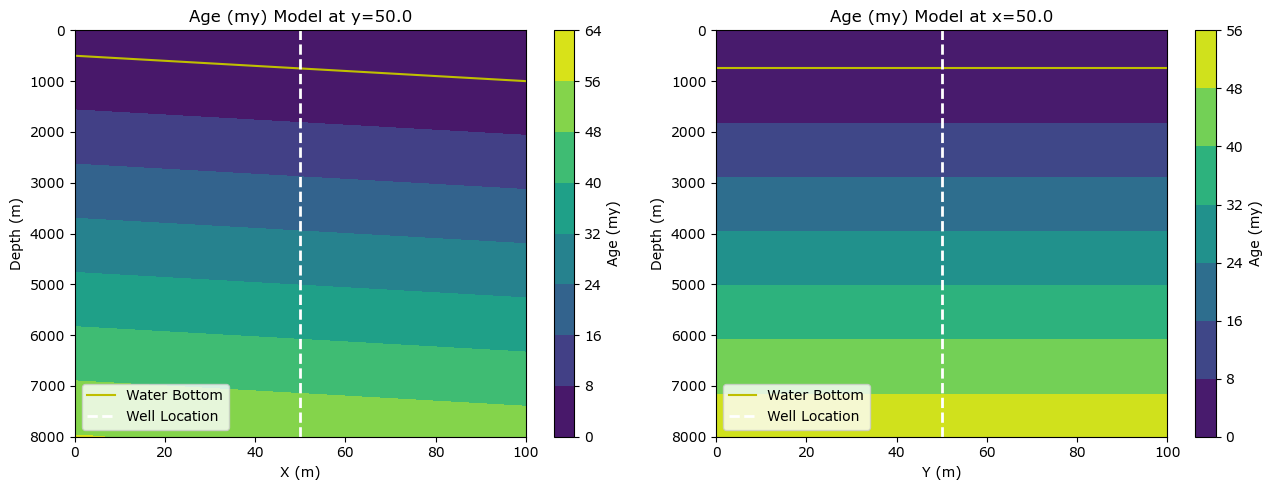

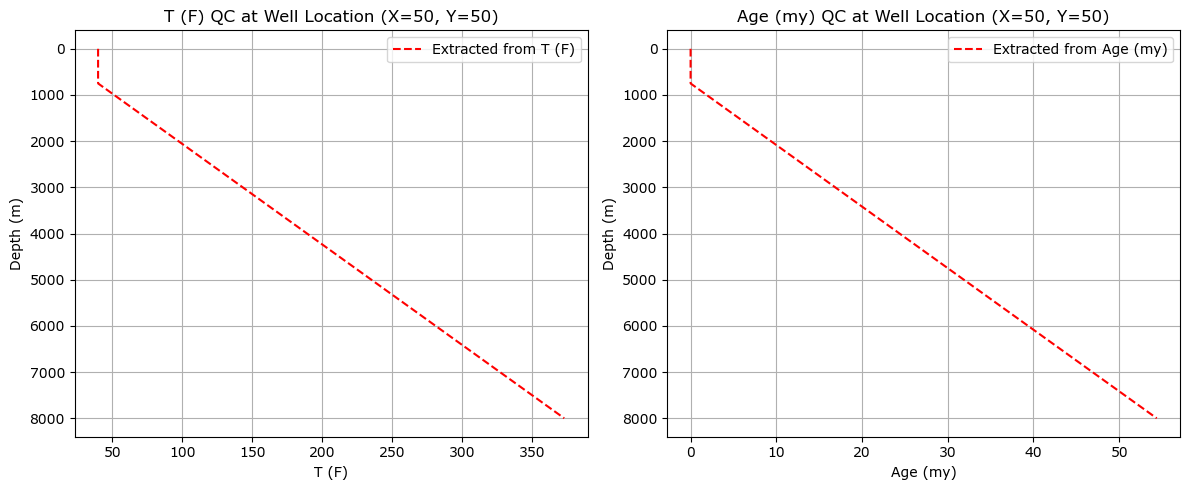

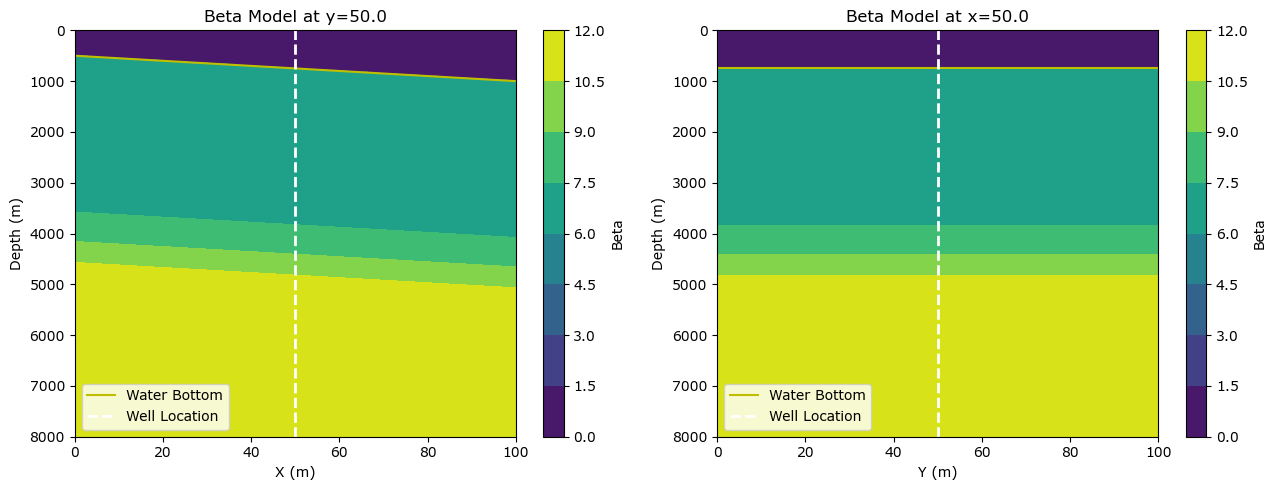

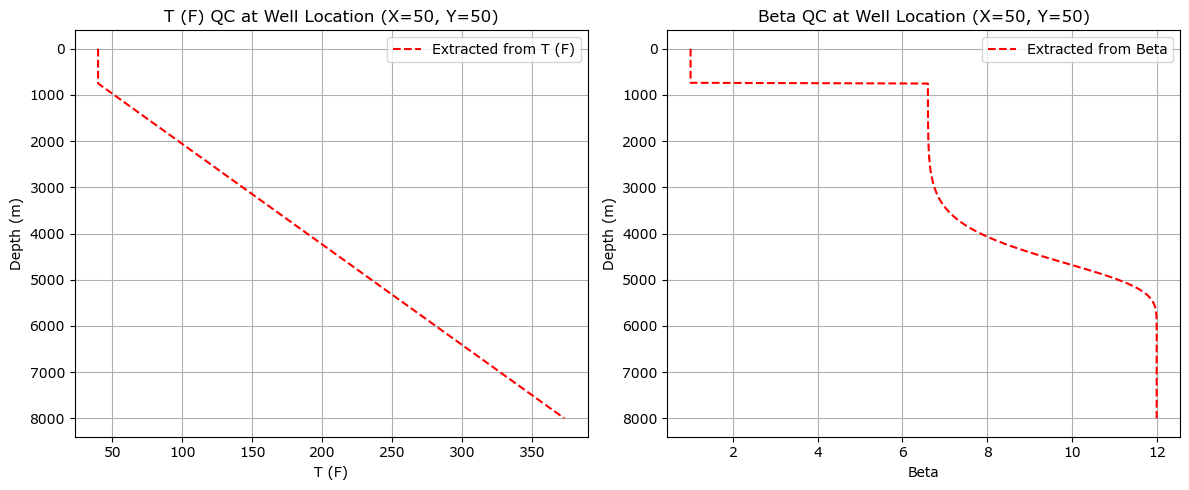

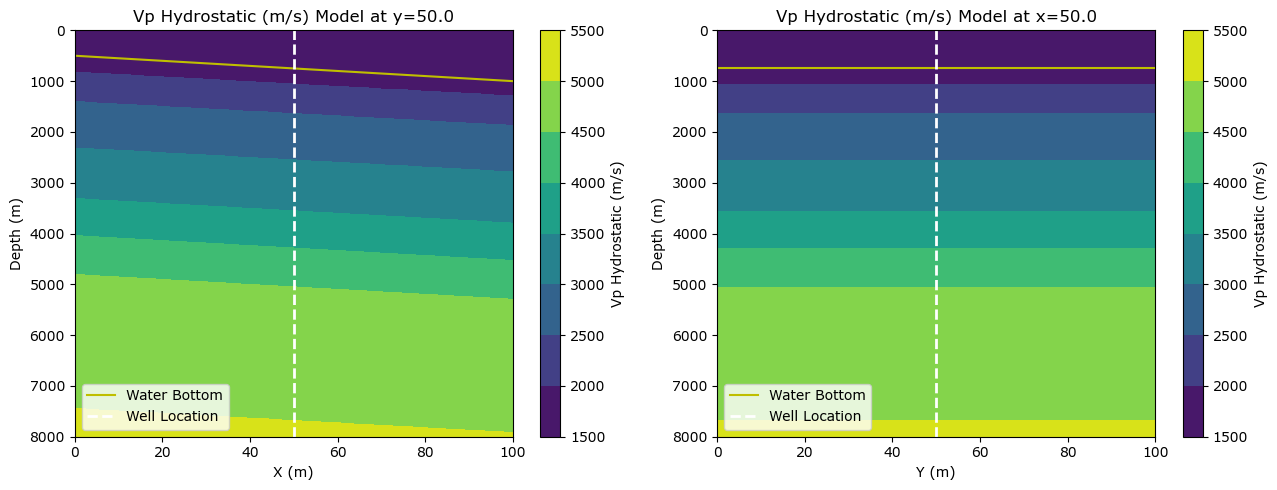

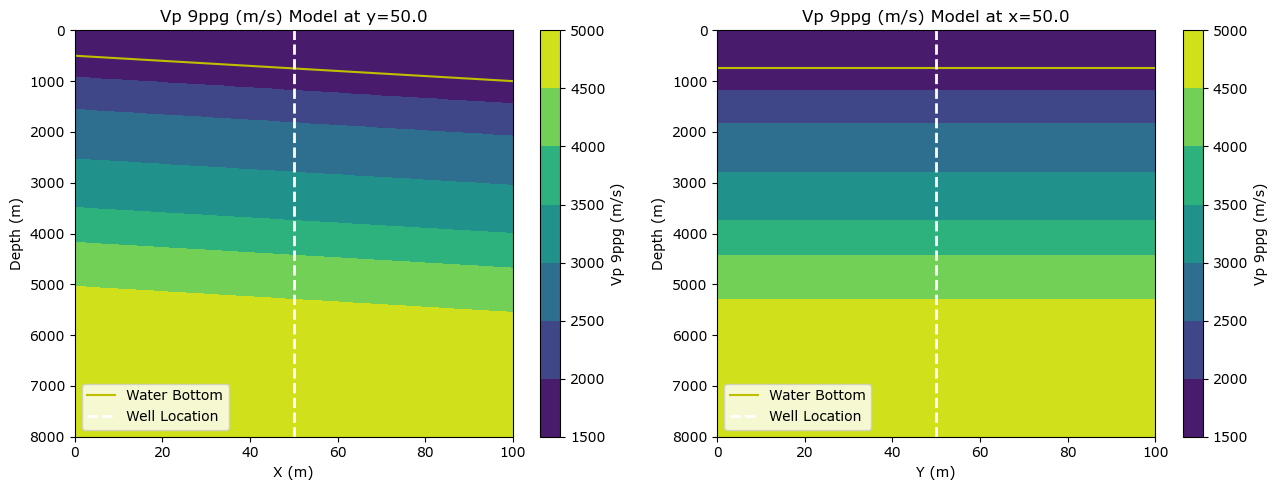

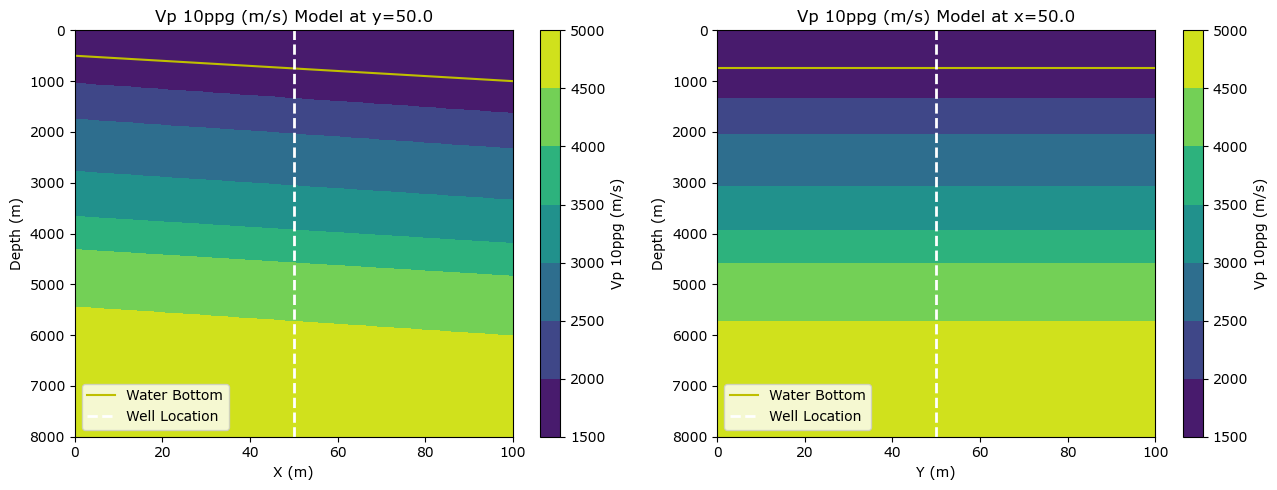

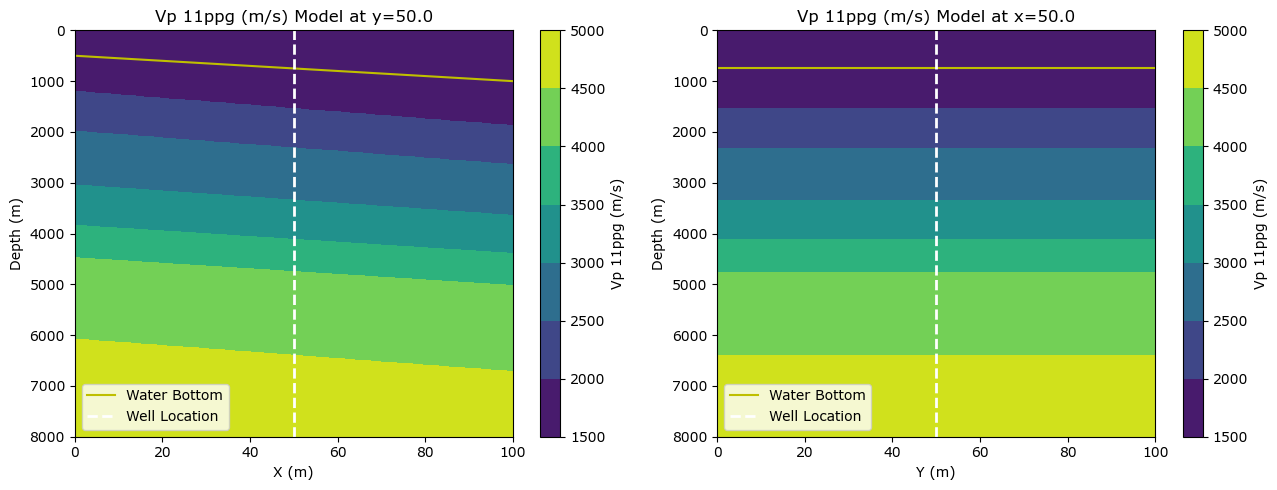

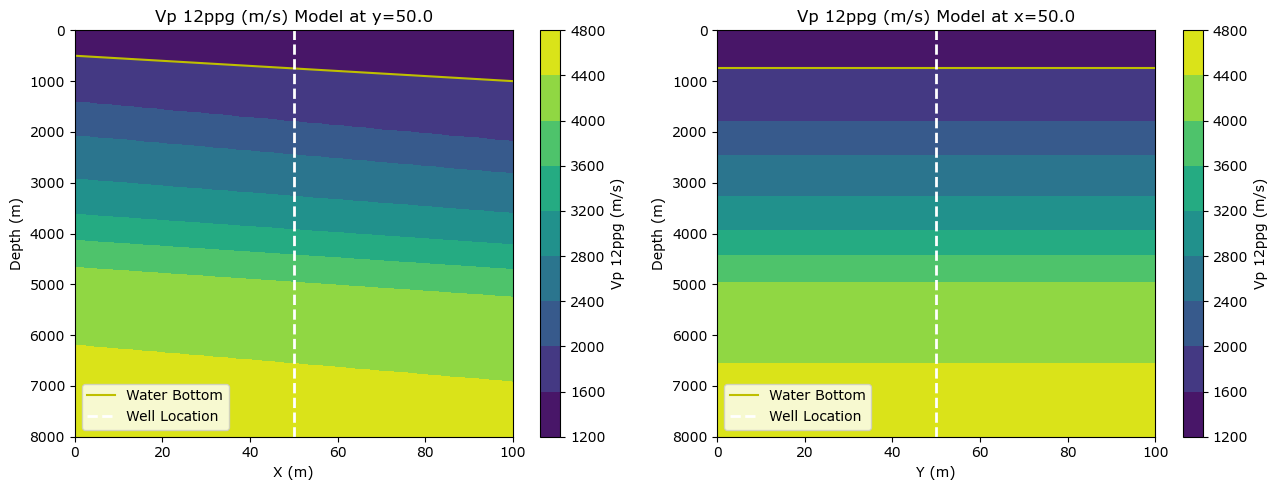

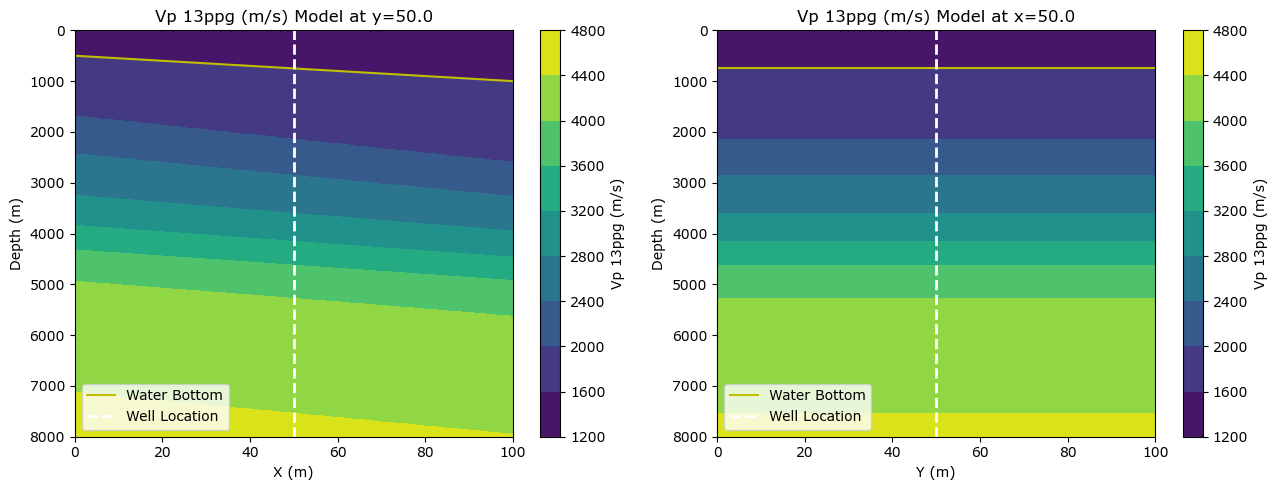

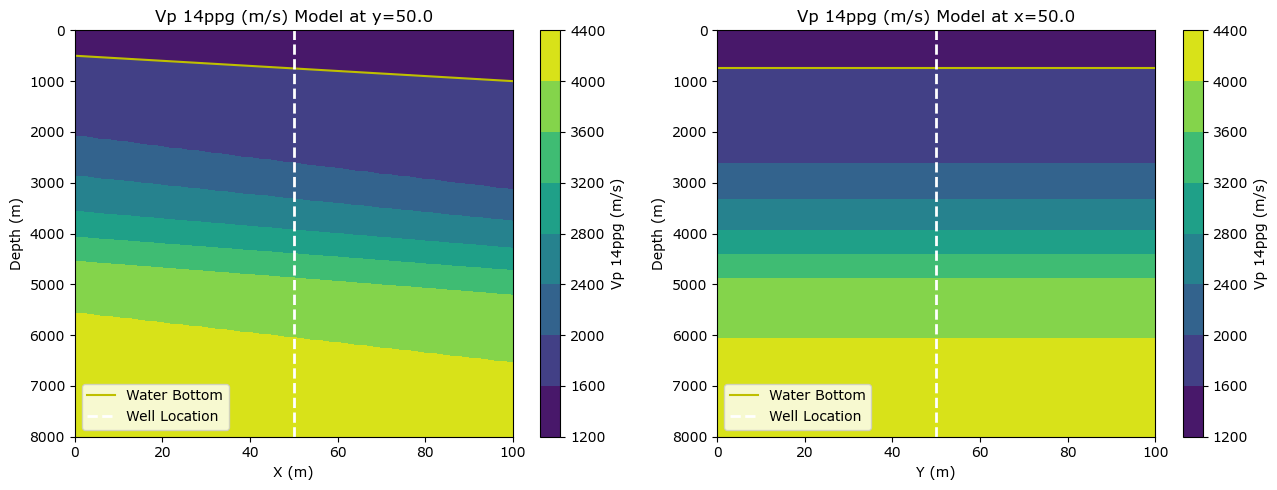

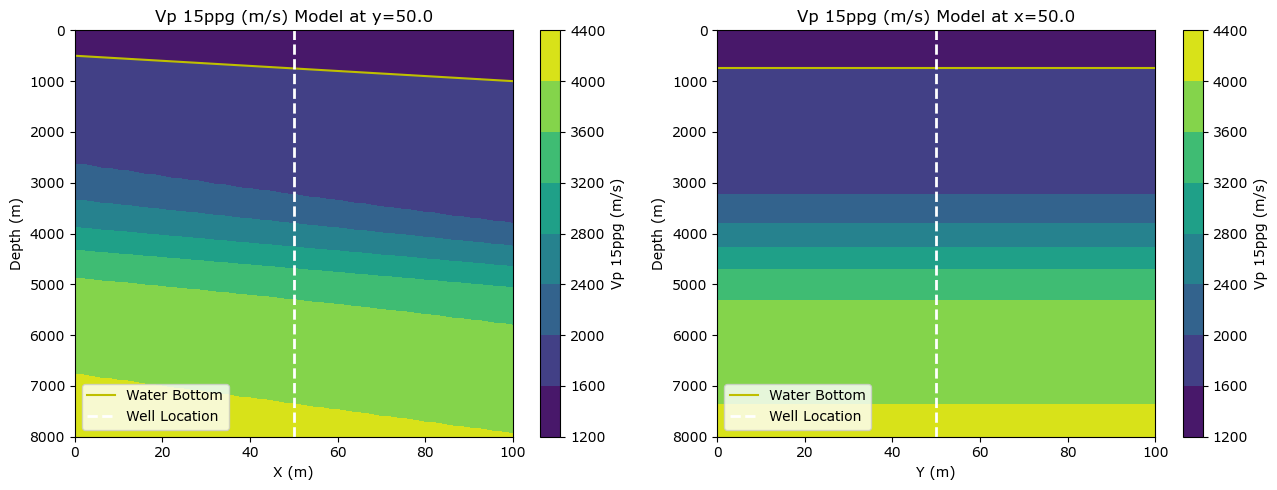

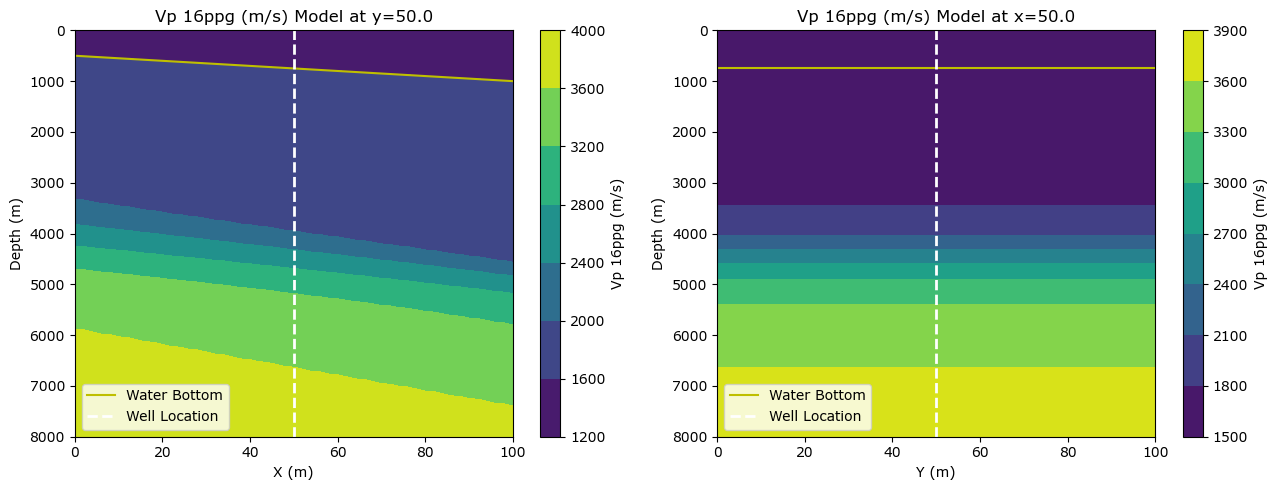

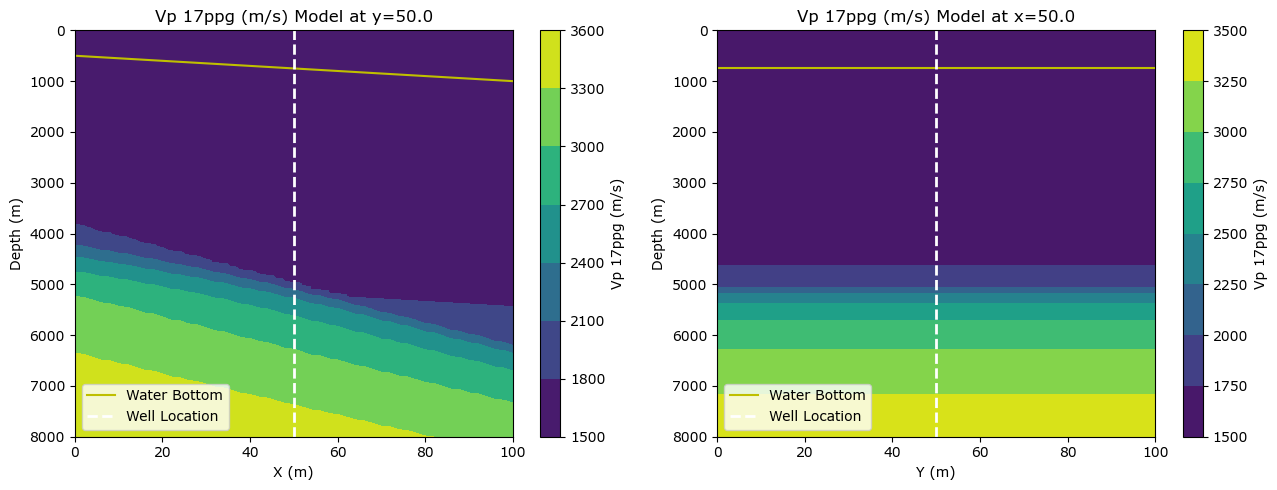

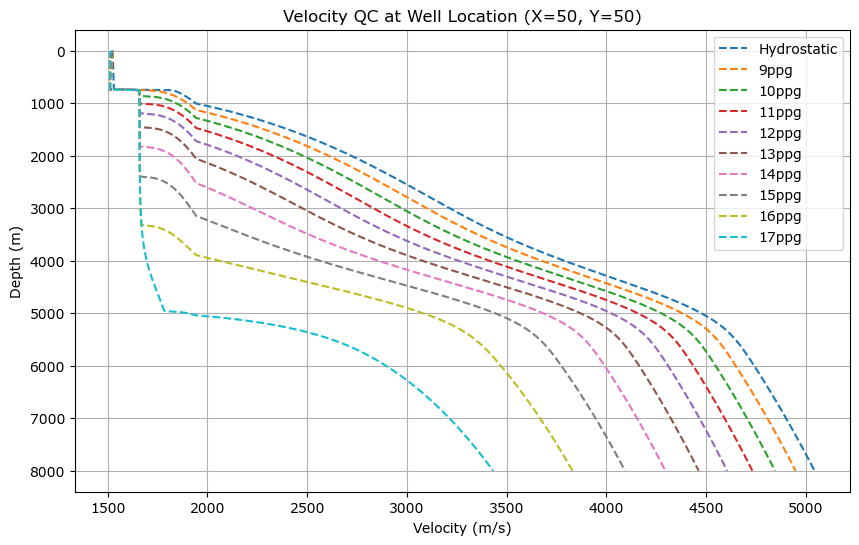

In [12]:
# Build 3D RPT models

# Build Depth Scale model
depth_scale_model=np.zeros((len(x_grid), len(y_grid), len(depth_grid)))
depth_scale_model[:, :, :] = depth_grid
dz=depth_grid[1]-depth_grid[0]

# QC inine and xline
plot_model_sections(depth_scale_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Depth Scale (m)', y_index=25, x_index=25)

# Build Overburden Stress model
density_model = np.zeros((len(x_grid), len(y_grid), len(depth_grid)))
overburden_model = np.zeros((len(x_grid), len(y_grid), len(depth_grid)))

zbml_model = depth_scale_model - surface_3d
# Mute above water bottom to 0
zbml_model[depth_grid<surface_3d]=0

# QC inine and xline
plot_model_sections(zbml_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Zbml (m)', y_index=25, x_index=25)

# QC well profiles
plot_well_profiles(depth_scale_model, zbml_model, x_grid, y_grid, depth_grid, model_1_name='Depth Scale (m)', model_2_name='ZBML (m)')

rosfl=1.8 # Seafloor density, g/cc
a=0.35 # Coefficient in Trougott's equation
b=0.25 # Coefficient in Trougott's equation
c=3125 # Coefficient in Trougott's equation
row=1.03 # Sea water density, g/cc

density_model = rosfl + a*(zbml_model*3.2808/c)**b

# Mute above water bottom density to row
density_model[depth_grid<surface_3d]=row

# QC density model's inine and xline
plot_model_sections(density_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Density (g/cc)', y_index=25, x_index=25)

atms2psi = 14.69595 # Atmosphere pressure in psi
gcc2psift=0.4332 # 1 g/cc = 0.4332 psi/ft
psift2ppg = 19.27 # 1 psi/ft = 19.27 ppg (lb/gal)

# Calculate overburden stress model
ob_model = np.cumsum(density_model, axis=2)*gcc2psift*3.2808*dz+atms2psi
kb=10 # kelly bush depth, m
obg_model=ob_model/((depth_scale_model+kb)*3.2808)*psift2ppg
# Mute above water bottom obg to 8.6
obg_model[depth_grid<surface_3d]=8.6


# QC OB and OBG model's inine and xline
plot_model_sections(ob_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='OB (psi)', y_index=25, x_index=25)
plot_model_sections(obg_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='OBG (ppg)', y_index=25, x_index=25)

# QC well profiles
plot_well_profiles(density_model, ob_model, x_grid, y_grid, depth_grid, model_1_name='Density (g/cc)', model_2_name='OB (psi)', x_well=50, y_well=50)
plot_well_profiles(obg_model, ob_model, x_grid, y_grid, depth_grid, model_1_name='OBG (ppg)', model_2_name='OB (psi)', x_well=50, y_well=50)

# Build Temperature gradient model

tg=0.014 # thermal gradient F/ft, GOM average 0.014-0.016 F/ft
t0=40 # Seafloor temperature F
temp_model=t0+tg*zbml_model*3.2808

# Mute above water bottom to 40 F
temp_model[depth_grid<surface_3d] = 40

# QC Temperature model's inine and xline
plot_model_sections(temp_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='T (F)', y_index=25, x_index=25)

# Build Geologic Age model

br=60/8000 # Burial rate: million years / meter
age_model=br*zbml_model

# Mute above water bottom to 0 my
age_model[depth_grid<surface_3d] = 0

# QC Age model's inine and xline
plot_model_sections(age_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Age (my)', y_index=25, x_index=25)

# QC well profiles
plot_well_profiles(temp_model, age_model, x_grid, y_grid, depth_grid, model_1_name='T (F)', model_2_name='Age (my)', x_well=50, y_well=50)

# Build Diagenesis Beta function model

R = 1.987 #cal/K/mol
dE = 19.39e3 #cal/mol (Dutta: 19.3+-0.7 kcal/mol)
A = 4e10 #/million yrs (Dutta: 0.4/yr)
b0=6.6
b1=12

dt_model = np.diff(age_model, axis=2)
dt_model = np.insert(dt_model, 0, 0, axis=2)

Tk_model=(5/9)*(temp_model-32)+273.15 # Convert temp from F to K

S_model = A * np.exp(-dE / R / Tk_model) * dt_model
S_model = np.cumsum(S_model, axis=2)
S_model = 1 * np.exp(-S_model)

beta_model=b0*S_model+b1*(1-S_model)
# Mute above water bottom to 0
beta_model[depth_grid<surface_3d] = 1

# QC beta model's inine and xline
plot_model_sections(beta_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Beta', y_index=25, x_index=25)
# QC well profiles
plot_well_profiles(temp_model, beta_model, x_grid, y_grid, depth_grid, model_1_name='T (F)', model_2_name='Beta', x_well=50, y_well=50)


# Build RPT 3D models from Hydrostatic, 9ppg to 17ppg

eff0=27500
dtm=53 # solid slowness, us/ft
xdt=2.3 # lithology coefficient

'''
# Calculate Hydrostatic PPG and Effective stress models
ppg_hyd=8.6

pp_hyd_model=ppg_hyd/psift2ppg*(depth_scale_model)*3.2808 # a pp model in psi
eff_hyd_model=ob_model-pp_hyd_model # a effective stress model in psi

# QC a pp and eff model's inine and xline
plot_model_sections(pp_hyd_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='PP Hyd (psi)', y_index=25, x_index=25)
plot_model_sections(eff_hyd_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Eff Hyd (psi)', y_index=25, x_index=25)

# QC well profiles
plot_well_profiles(pp_hyd_model, eff_hyd_model, x_grid, y_grid, depth_grid, model_1_name='PP Hyd (psi)', model_2_name='Eff Hyd (psi)', x_well=50, y_well=50)

# Convert Effective Stress to Porosity using Dutta's eq
eff0=27500

eff_hyd_model[eff_hyd_model <= 0] = 1 # remove negative or zero values in eff
phi_hyd_model=np.log(eff0/eff_hyd_model)/beta_model/(1+np.log(eff0/eff_hyd_model)/beta_model)

# QC a phi model's inine and xline
plot_model_sections(phi_hyd_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Porosity Hyd', y_index=25, x_index=25)

# Convert Porosity to Vp using Issler eq

dtm=53 # solid slowness, us/ft
xdt=2.3 # lithology coefficient

dt_hyd_model=dtm*(1-phi_hyd_model)**(-xdt)
vp_hyd_model=1e6/dt_hyd_model/3.2808

# QC a vp hydrostatic model's inine and xline
plot_model_sections(vp_hyd_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Vp Hydrostatic (m/s)', y_index=25, x_index=25)

# QC well profiles
plot_well_profiles(phi_hyd_model, vp_hyd_model, x_grid, y_grid, depth_grid, model_1_name='Porosity Hyd', model_2_name='Vp Hyd (m/s)', x_well=50, y_well=50)
'''

# Repeat for ppg = 9 to 17
ppg = np.arange(9, 18)
ppg = np.insert(ppg,0,8.6) # Add hydrostatic to ppg[0], now ppg[0] is the hydrostatic model

# Initialize pp_model with the desired shape
pp_model = np.zeros((len(ppg), len(x_grid), len(y_grid), len(depth_grid)))
eff_model = np.zeros((len(ppg), len(x_grid), len(y_grid), len(depth_grid)))
phi_model = np.zeros((len(ppg), len(x_grid), len(y_grid), len(depth_grid)))
dt_model = np.zeros((len(ppg), len(x_grid), len(y_grid), len(depth_grid)))
vp_model = np.zeros((len(ppg), len(x_grid), len(y_grid), len(depth_grid)))
vp_rpt_extracted = np.zeros((len(depth_grid),len(ppg)))

# Loop through ppg and apply the calculation for each value
for i in range(len(ppg)):
    pp_model[i] = (ppg[i] / psift2ppg) * depth_scale_model * 3.2808 # a pp model in psi
    eff_model[i] = ob_model-pp_model[i] # a effective stress model in psi
    eff_model[eff_model <= 0] = 1 # remove negative or zero values in eff
    phi_model[i]=np.log(eff0/eff_model[i])/beta_model/(1+np.log(eff0/eff_model[i])/beta_model)
    dt_model[i]=dtm*(1-phi_model[i])**(-xdt)
    vp_model[i]=1e6/dt_model[i]/3.2808
    
# Correct shallow Vp using Reuss eq

dtf=204 # Water slowness
rom=2.65 # Solid density
rof=1.5 # Water density

kr_model=1/(dtm**2*(1-phi_model)/rom+dtf**2*phi_model/rof)
ror_model=rom*(1-phi_model)+rof*phi_model
dtr_model=np.sqrt(ror_model/kr_model)
vpr_model=1e6/dtr_model/3.2808

idx = vp_model < vpr_model
vp_model[idx] = vpr_model[idx]

for i in range(len(ppg)):
    # QC a vp model's inine and xline
    if i==0:
        plot_model_sections(vp_model[i], x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Vp Hydrostatic (m/s)', y_index=25, x_index=25)
    else:
        plot_model_sections(vp_model[i], x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name=f'Vp {i+8}ppg (m/s)', y_index=25, x_index=25)
    # Extract well profiles
    vp_rpt_extracted[:,i] = vp_model[i, well_x_index, well_y_index, :]

# QC well profiles
plt.figure(figsize=(10, 6))
plt.plot(vp_rpt_extracted, depth_grid, label=['Hydrostatic', '9ppg','10ppg','11ppg','12ppg','13ppg','14ppg','15ppg','16ppg','17ppg'], linestyle='--')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Depth (m)')
plt.title('Velocity QC at Well Location (X=50, Y=50)')
plt.gca().invert_yaxis()  # Depth increases downwards
plt.legend()
plt.grid(True)


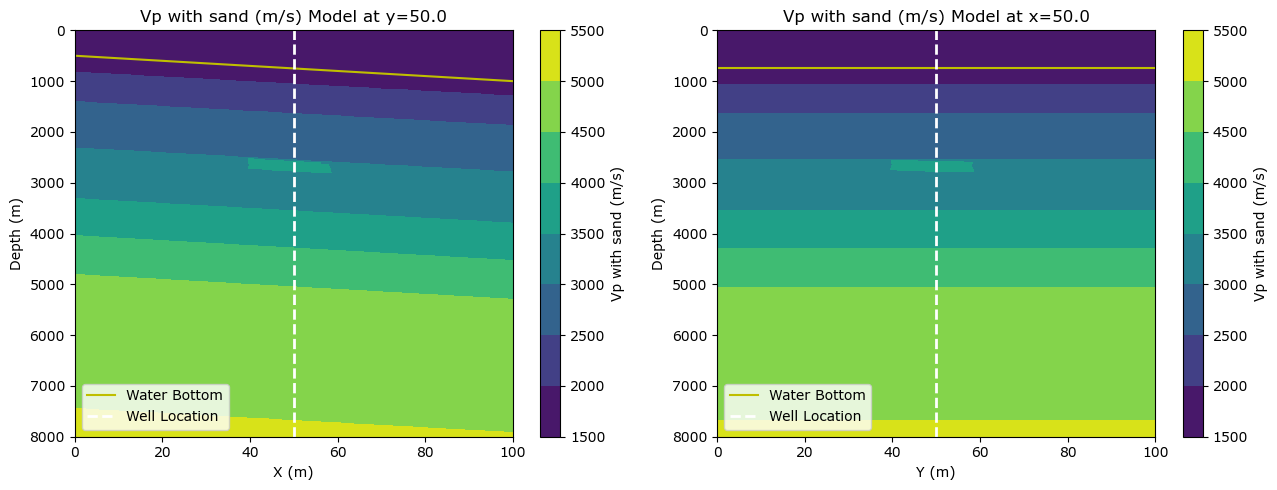

In [17]:
# Build 3D sand models

from vpvs2pr import vpvs2pr
from gassmnv import gassmnv

k1=36.6 # Bulk Modulus of quartz, Gpa
g1=45 # Shear Modulus of quartz, Gpa
d1=2.65 # Density of quartz, g/cc
k2=21 # Bulk Modulus of clay, Gpa
g2=7 # Shear Modulus of clay, Gpa
d2=2.58 # Density of clay, g/cc
kf=2.6891 # Water Bulk Modulus, Gpa
rhof=1.05 # Density of Water, g/cc

# Porisity trend, Athy's eq, to be calibrated

phi0=0.4
c0=0.0002
phi_trend_model=phi0*np.exp(-c0*zbml_model) # sand porosity trend, Athy eq
# QC
#plot_model_sections(phi_trend_model, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name='Porosity trend', y_index=25, x_index=25)

# Calculate vp_sand vs vclay
vclay=np.arange(0,1.1,0.1) # Define vclay array

kr=((1-vclay)/k1+vclay/k2)**(-1)
kv=k1*(1-vclay)+k2*vclay
kh=(kr+kv)/2
# kh=kr # fake soft sand model

gr=((1-vclay)/g1+vclay/g2)**(-1)
gv=g1*(1-vclay)+g2*vclay
gh=(gr+gv)/2
# gh=gr # fake soft sand model

ds=(1-vclay)*d1+vclay*d2 # Solid phase density, g/cc
vps=((kh+gh*4/3)/ds)**0.5 # Solid phase vp, km/s
vpf=1.5 # water vp, km/s

# Wet case

vp_sand_model=np.zeros((len(vclay),len(x_grid), len(y_grid), len(depth_grid)))
ro_sand_model=np.zeros((len(vclay),len(x_grid), len(y_grid), len(depth_grid)))
ip_sand_model=np.zeros((len(vclay),len(x_grid), len(y_grid), len(depth_grid)))
vs_sand_model=np.zeros((len(vclay),len(x_grid), len(y_grid), len(depth_grid)))

for i in range(len(vclay)):
    vp_sand_model[i]=(1-phi_trend_model)**2*vps[i]+phi_trend_model*vpf # km/s
    #plot_model_sections(vp_sand_model[i], x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name=f'Vp sand (vclay={i*10}%) (km/s)', y_index=25, x_index=25)
    ro_sand_model[i]=phi_trend_model*rhof+(1-phi_trend_model)*ds[i]
    #plot_model_sections(ro_sand_model[i], x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name=f'Density sand (vclay={i*10}%) (g/cc)', y_index=25, x_index=25)
    ip_sand_model[i]=vp_sand_model[i]*ro_sand_model[i]
    vs_sand_model[i]=(0.862*(vp_sand_model[i])-1.172) # km/s, Castagna Mudrock line

vpvs_sand_model=vp_sand_model/vs_sand_model
pr_sand_model=vpvs2pr(vpvs_sand_model)

# Choose a shale model and sand model
ppg_index=0
vclay_index=0

vp_model_3d=vp_model[ppg_index]
vp_sand_model_3d=vp_sand_model[vclay_index]
vs_sand_model_3d=vs_sand_model[vclay_index]
ro_sand_model_3d=ro_sand_model[vclay_index]

# Oil case

rhof2=0.7 # Density of oil mixture, g/cc
kf2=0.7 # Bulk modulus of oil mixture, Gpa

vp2, vs2, ro2, k2 = gassmnv(vp_sand_model_3d, vs_sand_model_3d, ro_sand_model_3d, rhof, kf, rhof2, kf2, kh[vclay_index], phi_trend_model) # Doing fluid sub with Gassmann eq

ip2=vp2*ro2
vpvs2=vp2/vs2
pr2=vpvs2pr(vpvs2)

# Gas case

rhof2=0.2 # Density of gas mixture, g/cc
kf2=0.2 # Bulk modulus of gas mixture, Gpa

vp3, vs3, ro3, k3 = gassmnv(vp_sand_model_3d, vs_sand_model_3d, ro_sand_model_3d, rhof, kf, rhof2, kf2, kh[vclay_index], phi_trend_model) # Doing fluid sub with Gassmann eq

ip3=vp3*ro3
vpvs3=vp3/vs3
pr3=vpvs2pr(vpvs3)

# Merge the sand model into the sand body only

for i in range(x_min_index, x_max_index):
    for j in range(y_min_index, y_max_index):
        for k in range(top_index_abs, bottom_index_abs):
            if lithology_model[i, j, k] == 1:  # Check if it's part of the sand body
                if k < gas_index_abs:
                    vp_model_3d[i,j,k]=vp3[i,j,k]*1000 # Gas
                elif k < oil_index_abs:
                    vp_model_3d[i,j,k]=vp2[i,j,k]*1000 # Oil
                else:
                    vp_model_3d[i,j,k]=vp_sand_model_3d[i,j,k]*1000 # Water

plot_model_sections(vp_model_3d, x_grid, y_grid, depth_grid, surface_array, x_well, y_well, name=f'Vp with sand (m/s)', y_index=25, x_index=25)
    


In [ ]:
# Simulate Synthetic AVO response in 3D

# Create Stack in 3D

# QC inline and at well location